## **IMPORTS**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Biblioteca para fazer a PADRONIZAÇÃO
from sklearn.preprocessing import StandardScaler

# Biblioteca para fazer a NORMALIZAÇÃO
from sklearn.preprocessing import MinMaxScaler

# Bilioteca para separação de dados em treino e teste
from sklearn.model_selection import train_test_split

from sklearn.neural_network import MLPClassifier

# Biblioteca para calcular a acuracia do modelo
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score

import lime
import lime.lime_tabular

from anchor import utils
from anchor import anchor_tabular

from imblearn.over_sampling import ADASYN
from collections import Counter

from scipy.stats import tukey_hsd
from scipy import stats

## **LEITURA DOS DADOS**

In [16]:
data = pd.read_csv('../Base de Dados/Dados_49_V.csv', na_values='?')

#data = pd.read_csv('../Base de Dados/Dados_10_V_FISHER.csv', na_values='?')

print(data.shape)
data.head()

(2185, 11)


,inseminacao_2cat,total_animais_prop,teste_bruc,compra_repr,venda_repr,dest_leilao,vacina_semqqidade,piquete_parto,assist_vet,tipo_assist,resul_prop
0,0,15,0,0,0,0,0,0,0,-1,0
1,0,142,0,1,1,0,1,1,0,-1,0
2,0,40,0,1,1,0,-1,1,0,-1,0
3,0,68,0,1,0,0,1,0,0,-1,0
4,0,38,0,0,0,0,0,0,0,-1,0


In [17]:
# Gerando um DataFrame das variáveis preditoras originais SEM a variável TARGET
VAR_PREDITORAS_ORIG = data.drop('resul_prop', axis = 1)

# Gerando um DataFrame somente da variavel TARGET
VAR_TARGET = data['resul_prop']

## **NORMALIZAÇÃO**

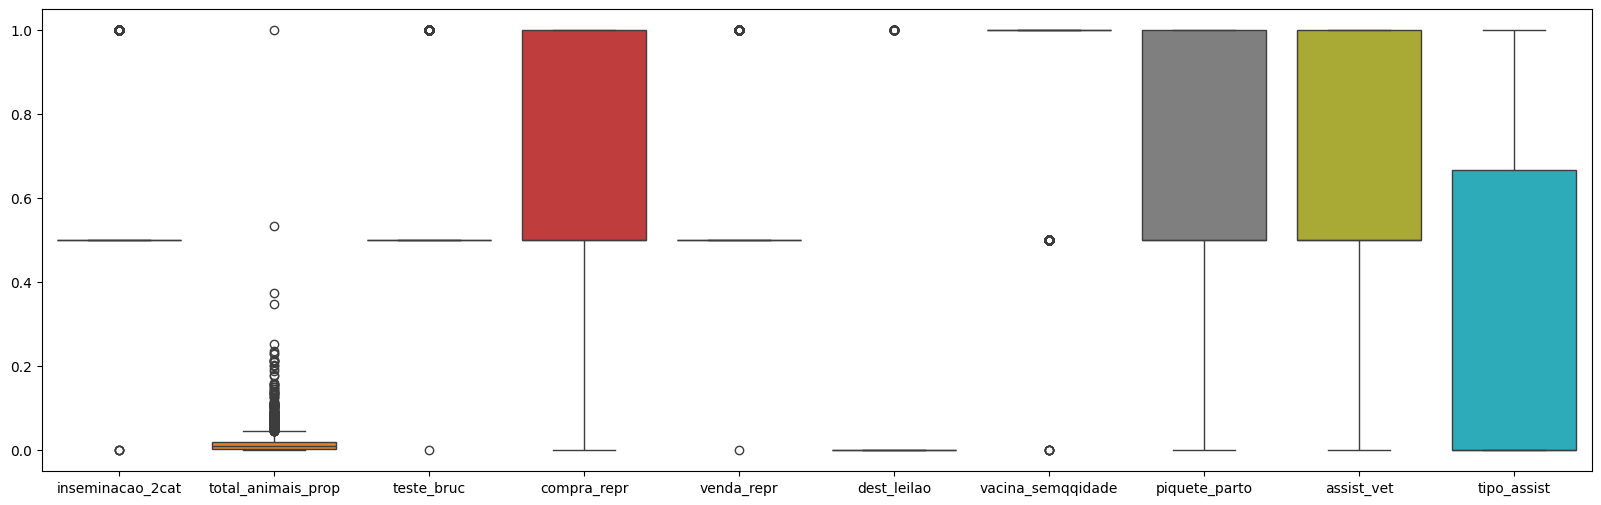

In [18]:
# Criando um objeto para NORMALIZAR os dados
obj_normalizacao = MinMaxScaler().fit(VAR_PREDITORAS_ORIG)

# Aplicando a NORMALIZAÇÃO
VAR_PREDITORAS_NORM = obj_normalizacao.transform(VAR_PREDITORAS_ORIG)

# Transformando para DataFrame e nomeando as colunas
VAR_PREDITORAS_NORM = pd.DataFrame(VAR_PREDITORAS_NORM)

VAR_PREDITORAS_NORM.columns = data.drop('resul_prop', axis = 1).columns

VAR_PREDITORAS_NORM

plt.figure(figsize=(20,6))
ax = sns.boxplot(data=VAR_PREDITORAS_NORM)

## **AGRUPAMENTO**

In [19]:
DATA_NORM = VAR_PREDITORAS_NORM.assign(resul_prop=VAR_TARGET)
DATA_NORM_NEG = VAR_PREDITORAS_NORM.assign(resul_prop=VAR_TARGET).query('resul_prop == 0').reset_index(drop=True)
DATA_NORM_POS = VAR_PREDITORAS_NORM.assign(resul_prop=VAR_TARGET).query('resul_prop == 1').reset_index(drop=True)

kmeans = KMeans(n_clusters=4, random_state=0, n_init="auto").fit(DATA_NORM_NEG.drop('resul_prop', axis = 1))
#print(kmeans.labels_)

#print(pd.DataFrame(kmeans.labels_))
DATA_NORM_NEG = DATA_NORM_NEG.assign(group=pd.DataFrame(kmeans.labels_))

DATA_NORM_NEG_GROUP0 = DATA_NORM_NEG.query('group == 0')
#print(DATA_NORM_NEG_GROUP0.shape)

DATA_NORM_NEG_GROUP1 = DATA_NORM_NEG.query('group == 1')
#print(DATA_NORM_NEG_GROUP1.shape)

DATA_NORM_NEG_GROUP2 = DATA_NORM_NEG.query('group == 2')
#print(DATA_NORM_NEG_GROUP2.shape)

DATA_NORM_NEG_GROUP3 = DATA_NORM_NEG.query('group == 3')
#print(DATA_NORM_NEG_GROUP3.shape)

DATA_NORM_NEG_GROUP0 = DATA_NORM_NEG_GROUP0.sample(frac=1).drop('group', axis = 1).reset_index(drop=True)
DATA_NORM_NEG_GROUP1 = DATA_NORM_NEG_GROUP1.sample(frac=1).drop('group', axis = 1).reset_index(drop=True)
DATA_NORM_NEG_GROUP2 = DATA_NORM_NEG_GROUP2.sample(frac=1).drop('group', axis = 1).reset_index(drop=True)
DATA_NORM_NEG_GROUP3 = DATA_NORM_NEG_GROUP3.sample(frac=1).drop('group', axis = 1).reset_index(drop=True)

## **RNA + Replicação**

In [20]:
accuracy_rep = []

neg_prec_rep = []
neg_recall_rep = []
neg_fscore_rep = []

pos_prec_rep = []
pos_recall_rep = []
pos_fscore_rep = []

auc_rep = []

num_am_grupo_neg = 30
num_am_grupo_pos = 60

for i in range (0,100):
    DATA_NORM_NEG_GROUP0 = DATA_NORM_NEG_GROUP0.sample(frac=1).reset_index(drop=True)
    DATA_NORM_NEG_GROUP1 = DATA_NORM_NEG_GROUP1.sample(frac=1).reset_index(drop=True)
    DATA_NORM_NEG_GROUP2 = DATA_NORM_NEG_GROUP2.sample(frac=1).reset_index(drop=True)
    DATA_NORM_NEG_GROUP3 = DATA_NORM_NEG_GROUP3.sample(frac=1).reset_index(drop=True)
    
    #-------------------------- MONTANDO CONJUNTO DE TREINO -------------------------------
    CLASSE_NEG = pd.concat([DATA_NORM_NEG_GROUP0.head(num_am_grupo_neg), 
        DATA_NORM_NEG_GROUP1.head(num_am_grupo_neg),
        DATA_NORM_NEG_GROUP2.head(num_am_grupo_neg),
        DATA_NORM_NEG_GROUP3.head(num_am_grupo_neg)], ignore_index = True)

    DATA_NORM_POS = DATA_NORM_POS.sample(frac=1).reset_index(drop=True)
    CLASSE_POS = pd.concat([DATA_NORM_POS.head(num_am_grupo_pos),DATA_NORM_POS.head(num_am_grupo_pos)], ignore_index = True)

    CONJ_TRAIN = pd.concat([CLASSE_NEG,CLASSE_POS]).sample(frac=1).reset_index(drop=True)

    X_TRAIN = CONJ_TRAIN.drop('resul_prop', axis = 1)
    Y_TRAIN = CONJ_TRAIN['resul_prop']


    #-------------------------- TREINANDO RNA -------------------------------
    rna = MLPClassifier(max_iter=1000000, hidden_layer_sizes = (30)).fit(X_TRAIN.values, Y_TRAIN.values)


    #-------------------------- TESTE RNA -------------------------------
    TEST_NEG = pd.concat([DATA_NORM_NEG_GROUP0.tail(len(DATA_NORM_NEG_GROUP0)-num_am_grupo_neg), 
        DATA_NORM_NEG_GROUP1.tail(len(DATA_NORM_NEG_GROUP1)-num_am_grupo_neg),
        DATA_NORM_NEG_GROUP2.tail(len(DATA_NORM_NEG_GROUP2)-num_am_grupo_neg),
        DATA_NORM_NEG_GROUP3.tail(len(DATA_NORM_NEG_GROUP3)-num_am_grupo_neg)], ignore_index = True)

    #TEST_NEG = pd.concat([DATA_NORM_NEG_GROUP0[num_am_grupo_neg:(num_am_grupo_neg+6)], 
    #    DATA_NORM_NEG_GROUP1[num_am_grupo_neg:(num_am_grupo_neg+6)],
    #    DATA_NORM_NEG_GROUP2[num_am_grupo_neg:(num_am_grupo_neg+6)],
    #    DATA_NORM_NEG_GROUP3[num_am_grupo_neg:(num_am_grupo_neg+6)]], ignore_index = True)

    TEST_POS = DATA_NORM_POS.tail(len(DATA_NORM_POS)-num_am_grupo_pos)

    X_TEST = pd.concat([TEST_NEG,TEST_POS], ignore_index = True).drop('resul_prop', axis = 1)
    Y_TEST = pd.concat([TEST_NEG,TEST_POS], ignore_index = True)['resul_prop']

    valores_preditos = rna.predict(X_TEST)


    #-------------------------- MÉTRICAS DE DESEMPENHO -------------------------------
    class_names = ['Negativo', 'Positivo']
   
    report = pd.DataFrame.from_dict(classification_report(Y_TEST, valores_preditos, target_names=class_names, output_dict=True))

    #ConfusionMatrixDisplay.from_estimator(rna, X_TEST, Y_TEST)
    #plt.show(3,5)

    accuracy_rep.append(accuracy_score(Y_TEST, valores_preditos))

    neg_prec_rep.append(report['Negativo']['precision'])
    neg_recall_rep.append(report['Negativo']['recall'])
    neg_fscore_rep.append(report['Negativo']['f1-score'])

    pos_prec_rep.append(report['Positivo']['precision'])
    pos_recall_rep.append(report['Positivo']['recall'])
    pos_fscore_rep.append(report['Positivo']['f1-score'])

    auc_rep.append(roc_auc_score(Y_TEST, rna.predict_proba(X_TEST)[:, 1]))

    #RocCurveDisplay.from_estimator(rna, X_TEST, Y_TEST)
    #plt.show()

RNA_rep = pd.DataFrame().assign(RNA_accuracy_rep=accuracy_rep,
                              RNA_neg_prec_rep=neg_prec_rep,
                              RNA_neg_recall_rep=neg_recall_rep,
                              RNA_neg_fscore_rep=neg_fscore_rep,
                              RNA_pos_prec_rep=pos_prec_rep,
                              RNA_pos_recall_rep=pos_recall_rep,
                              RNA_pos_fscore_rep = pos_fscore_rep,
                              RNA_auc_rep = auc_rep)

RNA_rep.to_csv("../Resultados/RNA_"+str(data.shape[1]-1)+"V_rep.csv", encoding = 'utf-8', index = False)

print("FIM")


c:\Users\caiod\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
c:\Users\caiod\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
c:\Users\caiod\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
c:\Users\caiod\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
c:\Users\caiod\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
c:\Users\caiod\AppDa

FIM


c:\Users\caiod\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
c:\Users\caiod\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


## **RNA + ADASYN**

In [21]:
accuracy_adasyn = []
neg_prec_adasyn = []
neg_recall_adasyn = []
neg_fscore_adasyn = []
pos_prec_adasyn = []
pos_recall_adasyn = []
pos_fscore_adasyn = []
auc_adasyn = []

num_am_grupo_neg = 60
num_am_grupo_pos = 60

for i in range (0,100):
    DATA_NORM_NEG_GROUP0 = DATA_NORM_NEG_GROUP0.sample(frac=1).reset_index(drop=True)
    DATA_NORM_NEG_GROUP1 = DATA_NORM_NEG_GROUP1.sample(frac=1).reset_index(drop=True)
    DATA_NORM_NEG_GROUP2 = DATA_NORM_NEG_GROUP2.sample(frac=1).reset_index(drop=True)
    DATA_NORM_NEG_GROUP3 = DATA_NORM_NEG_GROUP3.sample(frac=1).reset_index(drop=True)


    #-------------------------- ADASYN -------------------------------
    DATA_NORM_POS = DATA_NORM_POS.sample(frac=1).reset_index(drop=True)
    CLASSE_POS_ADASYN = DATA_NORM_POS.head(num_am_grupo_pos)

    CLASSE_NEG_ADASYN = DATA_NORM_NEG.drop('group', axis = 1)

    X_ADASYN_ORIGINAL = pd.concat([CLASSE_NEG_ADASYN.drop('resul_prop', axis = 1),
        CLASSE_POS_ADASYN.drop('resul_prop', axis = 1)]).reset_index(drop=True)

    Y_ADASYN_ORIGINAL = pd.concat([CLASSE_NEG_ADASYN['resul_prop'],
        CLASSE_POS_ADASYN['resul_prop']]).reset_index(drop=True)

    ada = ADASYN(sampling_strategy=0.12, n_neighbors=6)

    X_RESAMPLING, Y_RESAMPLING = ada.fit_resample(X_ADASYN_ORIGINAL, Y_ADASYN_ORIGINAL)


    #-------------------------- MONTANDO CONJUNTO DE TREINO -------------------------------
    CLASSE_NEG = pd.concat([DATA_NORM_NEG_GROUP0.head(num_am_grupo_neg),
        DATA_NORM_NEG_GROUP1.head(num_am_grupo_neg),
        DATA_NORM_NEG_GROUP2.head(num_am_grupo_neg),
        DATA_NORM_NEG_GROUP3.head(num_am_grupo_neg)], ignore_index = True)

    CLASSE_POS = X_RESAMPLING.assign(resul_prop=Y_RESAMPLING).query('resul_prop == 1').reset_index(drop=True)

    CONJ_TRAIN = pd.concat([CLASSE_NEG,CLASSE_POS]).sample(frac=1).reset_index(drop=True)

    X_TRAIN = CONJ_TRAIN.drop('resul_prop', axis = 1)
    Y_TRAIN = CONJ_TRAIN['resul_prop']


    #-------------------------- TREINANDO RNA -------------------------------
    rna = MLPClassifier(max_iter=1000000, hidden_layer_sizes = (30)).fit(X_TRAIN.values, Y_TRAIN.values)

    #-------------------------- TESTE RNA -------------------------------
    TEST_NEG = pd.concat([DATA_NORM_NEG_GROUP0.tail(len(DATA_NORM_NEG_GROUP0)-num_am_grupo_neg), 
        DATA_NORM_NEG_GROUP1.tail(len(DATA_NORM_NEG_GROUP1)-num_am_grupo_neg),
        DATA_NORM_NEG_GROUP2.tail(len(DATA_NORM_NEG_GROUP2)-num_am_grupo_neg),
        DATA_NORM_NEG_GROUP3.tail(len(DATA_NORM_NEG_GROUP3)-num_am_grupo_neg)], ignore_index = True)
    
    #TEST_NEG = pd.concat([DATA_NORM_NEG_GROUP0[num_am_grupo_neg:(num_am_grupo_neg+6)], 
    #    DATA_NORM_NEG_GROUP1[num_am_grupo_neg:(num_am_grupo_neg+6)],
    #    DATA_NORM_NEG_GROUP2[num_am_grupo_neg:(num_am_grupo_neg+6)],
    #    DATA_NORM_NEG_GROUP3[num_am_grupo_neg:(num_am_grupo_neg+6)]], ignore_index = True)

    TEST_POS = DATA_NORM_POS.tail(len(DATA_NORM_POS)-num_am_grupo_pos)

    X_TEST = pd.concat([TEST_NEG,TEST_POS], ignore_index = True).drop('resul_prop', axis = 1)
    Y_TEST = pd.concat([TEST_NEG,TEST_POS], ignore_index = True)['resul_prop']

    valores_preditos = rna.predict(X_TEST)

    #-------------------------- MÉTRICAS DE DESEMPENHO -------------------------------
    class_names = ['Negativo', 'Positivo']

    report = pd.DataFrame.from_dict(classification_report(Y_TEST, valores_preditos, target_names=class_names, output_dict=True))

    #ConfusionMatrixDisplay.from_estimator(rna, X_TEST, Y_TEST)
    #plt.show(3,5)

    accuracy_adasyn.append(accuracy_score(Y_TEST, valores_preditos))

    neg_prec_adasyn.append(report['Negativo']['precision'])
    neg_recall_adasyn.append(report['Negativo']['recall'])
    neg_fscore_adasyn.append(report['Negativo']['f1-score'])

    pos_prec_adasyn.append(report['Positivo']['precision'])
    pos_recall_adasyn.append(report['Positivo']['recall'])
    pos_fscore_adasyn.append(report['Positivo']['f1-score'])

    auc_adasyn.append(roc_auc_score(Y_TEST, rna.predict_proba(X_TEST)[:, 1]))

    #RocCurveDisplay.from_estimator(rna, X_TEST, Y_TEST)
    #plt.show()

RNA_adasyn = pd.DataFrame().assign(RNA_accuracy_adasyn=accuracy_adasyn,
                              RNA_neg_prec_adasyn=neg_prec_adasyn,
                              RNA_neg_recall_adasyn=neg_recall_adasyn,
                              RNA_neg_fscore_adasyn=neg_fscore_adasyn,
                              RNA_pos_prec_adasyn=pos_prec_adasyn,
                              RNA_pos_recall_adasyn=pos_recall_adasyn,
                              RNA_pos_fscore_adasyn = pos_fscore_adasyn,
                              RNA_auc_adasyn = auc_adasyn)

RNA_adasyn.to_csv("../Resultados/RNA_"+str(data.shape[1]-1)+"V_adasyn.csv", encoding = 'utf-8', index = False)

print("FIM")

c:\Users\caiod\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
c:\Users\caiod\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
c:\Users\caiod\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
c:\Users\caiod\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
c:\Users\caiod\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
c:\Users\caiod\AppDa

FIM


c:\Users\caiod\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
c:\Users\caiod\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


## **RNA CONTROLE**

In [22]:
accuracy_contr = []

neg_prec_contr = []
neg_recall_contr = []
neg_fscore_contr = []

pos_prec_contr = []
pos_recall_contr = []
pos_fscore_contr = []

auc_contr = []

num_am_grupo_neg = 15
num_am_grupo_pos = 60

for i in range (0,100):
    DATA_NORM_NEG_GROUP0 = DATA_NORM_NEG_GROUP0.sample(frac=1).reset_index(drop=True)
    DATA_NORM_NEG_GROUP1 = DATA_NORM_NEG_GROUP1.sample(frac=1).reset_index(drop=True)
    DATA_NORM_NEG_GROUP2 = DATA_NORM_NEG_GROUP2.sample(frac=1).reset_index(drop=True)
    DATA_NORM_NEG_GROUP3 = DATA_NORM_NEG_GROUP3.sample(frac=1).reset_index(drop=True)

    #-------------------------- MONTANDO CONJUNTO DE TREINO -------------------------------
    CLASSE_NEG = pd.concat([DATA_NORM_NEG_GROUP0.head(num_am_grupo_neg), 
        DATA_NORM_NEG_GROUP1.head(num_am_grupo_neg),
        DATA_NORM_NEG_GROUP2.head(num_am_grupo_neg),
        DATA_NORM_NEG_GROUP3.head(num_am_grupo_neg)], ignore_index = True)

    DATA_NORM_POS = DATA_NORM_POS.sample(frac=1).reset_index(drop=True)
    CLASSE_POS = DATA_NORM_POS.head(num_am_grupo_pos)

    CONJ_TRAIN = pd.concat([CLASSE_NEG,CLASSE_POS]).sample(frac=1).reset_index(drop=True)

    X_TRAIN = CONJ_TRAIN.drop('resul_prop', axis = 1)
    Y_TRAIN = CONJ_TRAIN['resul_prop']


    #-------------------------- TREINANDO RNA -------------------------------
    rna = MLPClassifier(max_iter=1000000, hidden_layer_sizes = (30)).fit(X_TRAIN.values, Y_TRAIN.values)


    #-------------------------- TESTE RNA -------------------------------
    TEST_NEG = pd.concat([DATA_NORM_NEG_GROUP0.tail(len(DATA_NORM_NEG_GROUP0)-num_am_grupo_neg), 
        DATA_NORM_NEG_GROUP1.tail(len(DATA_NORM_NEG_GROUP1)-num_am_grupo_neg),
        DATA_NORM_NEG_GROUP2.tail(len(DATA_NORM_NEG_GROUP2)-num_am_grupo_neg),
        DATA_NORM_NEG_GROUP3.tail(len(DATA_NORM_NEG_GROUP3)-num_am_grupo_neg)], ignore_index = True)

    #TEST_NEG = pd.concat([DATA_NORM_NEG_GROUP0[num_am_grupo_neg:(num_am_grupo_neg+6)], 
    #    DATA_NORM_NEG_GROUP1[num_am_grupo_neg:(num_am_grupo_neg+6)],
    #    DATA_NORM_NEG_GROUP2[num_am_grupo_neg:(num_am_grupo_neg+6)],
    #    DATA_NORM_NEG_GROUP3[num_am_grupo_neg:(num_am_grupo_neg+6)]], ignore_index = True)

    TEST_POS = DATA_NORM_POS.tail(len(DATA_NORM_POS)-num_am_grupo_pos)

    X_TEST = pd.concat([TEST_NEG,TEST_POS], ignore_index = True).drop('resul_prop', axis = 1)
    Y_TEST = pd.concat([TEST_NEG,TEST_POS], ignore_index = True)['resul_prop']

    valores_preditos = rna.predict(X_TEST)

    #-------------------------- MÉTRICAS DE DESEMPENHO -------------------------------
    class_names = ['Negativo', 'Positivo']

    report = pd.DataFrame.from_dict(classification_report(Y_TEST, valores_preditos, target_names=class_names, output_dict=True))

    #ConfusionMatrixDisplay.from_estimator(rna, X_TEST, Y_TEST)
    #plt.show(3,5)

    accuracy_contr.append(accuracy_score(Y_TEST, valores_preditos))

    neg_prec_contr.append(report['Negativo']['precision'])
    neg_recall_contr.append(report['Negativo']['recall'])
    neg_fscore_contr.append(report['Negativo']['f1-score'])

    pos_prec_contr.append(report['Positivo']['precision'])
    pos_recall_contr.append(report['Positivo']['recall'])
    pos_fscore_contr.append(report['Positivo']['f1-score'])

    auc_contr.append(roc_auc_score(Y_TEST, rna.predict_proba(X_TEST)[:, 1]))

    #RocCurveDisplay.from_estimator(rna, X_TEST, Y_TEST)
    #plt.show()

RNA_contr = pd.DataFrame().assign(RNA_accuracy_contr=accuracy_contr,
                              RNA_neg_prec_contr=neg_prec_contr,
                              RNA_neg_recall_contr=neg_recall_contr,
                              RNA_neg_fscore_contr=neg_fscore_contr,
                              RNA_pos_prec_contr=pos_prec_contr,
                              RNA_pos_recall_contr=pos_recall_contr,
                              RNA_pos_fscore_contr = pos_fscore_contr,
                              RNA_auc_contr = auc_contr)

RNA_contr.to_csv("../Resultados/RNA_"+str(data.shape[1]-1)+"V_contr.csv", encoding = 'utf-8', index = False)


print("FIM")

c:\Users\caiod\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
c:\Users\caiod\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
c:\Users\caiod\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
c:\Users\caiod\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
c:\Users\caiod\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
c:\Users\caiod\AppDa

FIM


c:\Users\caiod\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
c:\Users\caiod\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


## **ESTATÍSTICA**

### **AUC**

0.7095043968840864
0.49271969399211224


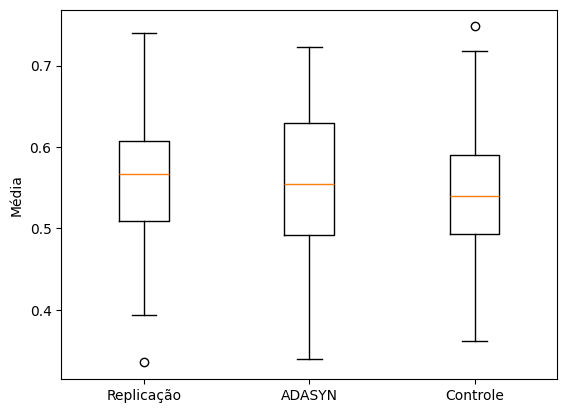

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      0.002     0.986    -0.025     0.028
 (0 - 2)      0.012     0.513    -0.014     0.039
 (1 - 0)     -0.002     0.986    -0.028     0.025
 (1 - 2)      0.011     0.614    -0.016     0.037
 (2 - 0)     -0.012     0.513    -0.039     0.014
 (2 - 1)     -0.011     0.614    -0.037     0.016



In [34]:
f_value, p_value = stats.f_oneway(auc_rep, auc_adasyn, auc_contr)

print(f_value)
print(p_value)

fig, ax = plt.subplots(1, 1)
ax.boxplot([auc_rep, auc_adasyn, auc_contr])
ax.set_xticklabels(["Replicação", "ADASYN", "Controle"])
ax.set_ylabel("Média")
plt.show()

res = stats.tukey_hsd(auc_rep, auc_adasyn, auc_contr)
print(res)

### **ACCURACY**

2.3304821961608098
0.0990248349416817


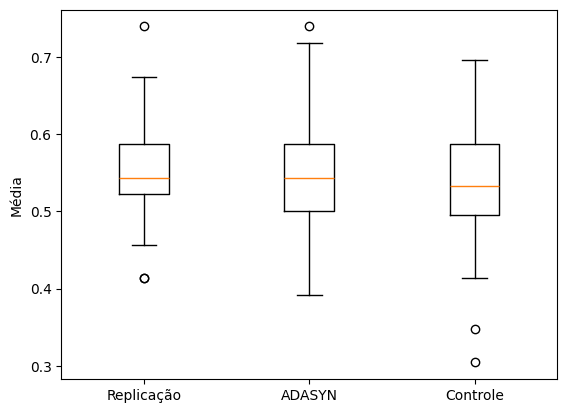

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      0.001     0.995    -0.021     0.022
 (0 - 2)      0.017     0.136    -0.004     0.039
 (1 - 0)     -0.001     0.995    -0.022     0.021
 (1 - 2)      0.017     0.165    -0.005     0.038
 (2 - 0)     -0.017     0.136    -0.039     0.004
 (2 - 1)     -0.017     0.165    -0.038     0.005



In [35]:
f_value, p_value = stats.f_oneway(accuracy_rep, accuracy_adasyn, accuracy_contr)

print(f_value)
print(p_value)

fig, ax = plt.subplots(1, 1)
ax.boxplot([accuracy_rep, accuracy_adasyn, accuracy_contr])
ax.set_xticklabels(["Replicação", "ADASYN", "Controle"])
ax.set_ylabel("Média")
plt.show()

res = stats.tukey_hsd(accuracy_rep, accuracy_adasyn, accuracy_contr)
print(res)

### **NEGATIVO PRECISION**

0.6542629889593643
0.5205725951519893


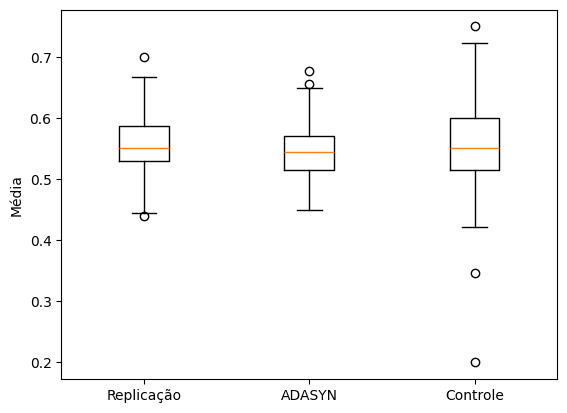

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      0.009     0.529    -0.010     0.028
 (0 - 2)      0.002     0.977    -0.018     0.021
 (1 - 0)     -0.009     0.529    -0.028     0.010
 (1 - 2)     -0.007     0.659    -0.026     0.012
 (2 - 0)     -0.002     0.977    -0.021     0.018
 (2 - 1)      0.007     0.659    -0.012     0.026



In [36]:
f_value, p_value = stats.f_oneway(neg_prec_rep, neg_prec_adasyn, neg_prec_contr)

print(f_value)
print(p_value)

fig, ax = plt.subplots(1, 1)
ax.boxplot([neg_prec_rep, neg_prec_adasyn, neg_prec_contr])
ax.set_xticklabels(["Replicação", "ADASYN", "Controle"])
ax.set_ylabel("Média")
plt.show()

res = stats.tukey_hsd(neg_prec_rep, neg_prec_adasyn, neg_prec_contr)
print(res)

### **POSITIVO PRECISION**

5.997839280942586
0.0027951201524239596


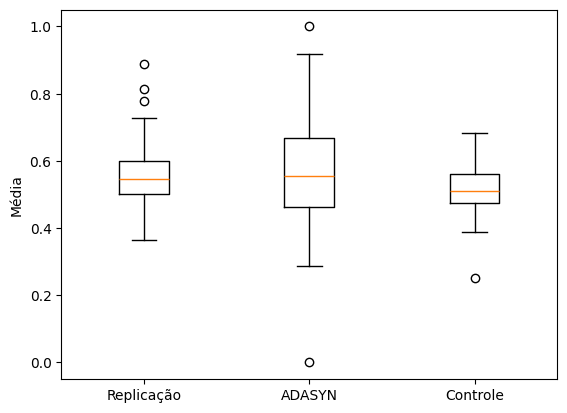

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.019     0.467    -0.056     0.019
 (0 - 2)      0.035     0.068    -0.002     0.072
 (1 - 0)      0.019     0.467    -0.019     0.056
 (1 - 2)      0.054     0.002     0.017     0.091
 (2 - 0)     -0.035     0.068    -0.072     0.002
 (2 - 1)     -0.054     0.002    -0.091    -0.017



In [37]:
f_value, p_value = stats.f_oneway(pos_prec_rep, pos_prec_adasyn, pos_prec_contr)

print(f_value)
print(p_value)

fig, ax = plt.subplots(1, 1)
ax.boxplot([pos_prec_rep, pos_prec_adasyn, pos_prec_contr])
ax.set_xticklabels(["Replicação", "ADASYN", "Controle"])
ax.set_ylabel("Média")
plt.show()

res = stats.tukey_hsd(pos_prec_rep, pos_prec_adasyn, pos_prec_contr)
print(res)

### **NEGATIVO RECALL**

220.17063521137055
2.2675355501459824e-59


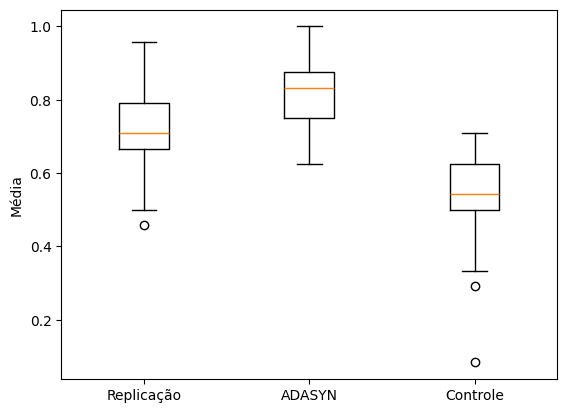

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.100     0.000    -0.131    -0.068
 (0 - 2)      0.175     0.000     0.144     0.206
 (1 - 0)      0.100     0.000     0.068     0.131
 (1 - 2)      0.275     0.000     0.243     0.306
 (2 - 0)     -0.175     0.000    -0.206    -0.144
 (2 - 1)     -0.275     0.000    -0.306    -0.243



In [39]:
f_value, p_value = stats.f_oneway(neg_recall_rep, neg_recall_adasyn, neg_recall_contr)

print(f_value)
print(p_value)

fig, ax = plt.subplots(1, 1)
ax.boxplot([neg_recall_rep, neg_recall_adasyn, neg_recall_contr])
ax.set_xticklabels(["Replicação", "ADASYN", "Controle"])
ax.set_ylabel("Média")
plt.show()

res = stats.tukey_hsd(neg_recall_rep, neg_recall_adasyn, neg_recall_contr)
print(res)

### **POSITIVO RECALL**

171.41801160302072
3.1851700830151017e-50


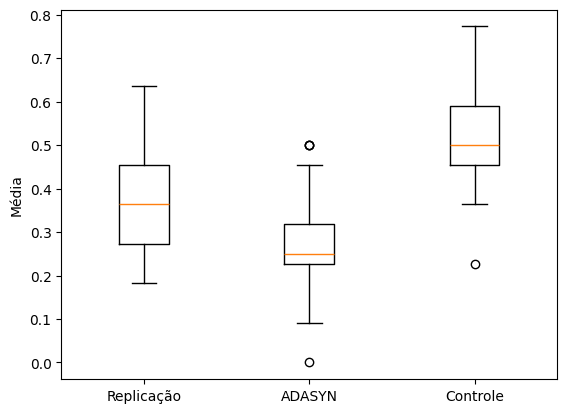

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      0.110     0.000     0.077     0.144
 (0 - 2)     -0.155     0.000    -0.188    -0.121
 (1 - 0)     -0.110     0.000    -0.144    -0.077
 (1 - 2)     -0.265     0.000    -0.299    -0.231
 (2 - 0)      0.155     0.000     0.121     0.188
 (2 - 1)      0.265     0.000     0.231     0.299



In [40]:
f_value, p_value = stats.f_oneway(pos_recall_rep, pos_recall_adasyn, pos_recall_contr)

print(f_value)
print(p_value)

fig, ax = plt.subplots(1, 1)
ax.boxplot([pos_recall_rep, pos_recall_adasyn, pos_recall_contr])
ax.set_xticklabels(["Replicação", "ADASYN", "Controle"])
ax.set_ylabel("Média")
plt.show()

res = stats.tukey_hsd(pos_recall_rep, pos_recall_adasyn, pos_recall_contr)
print(res)

### **NEGATIVO F1-SCORE**

73.04904728991136
1.581612819328471e-26


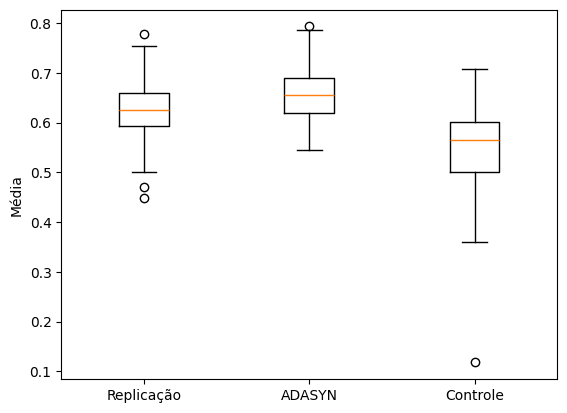

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.030     0.003    -0.052    -0.009
 (0 - 2)      0.079     0.000     0.057     0.101
 (1 - 0)      0.030     0.003     0.009     0.052
 (1 - 2)      0.109     0.000     0.087     0.131
 (2 - 0)     -0.079     0.000    -0.101    -0.057
 (2 - 1)     -0.109     0.000    -0.131    -0.087



In [41]:
f_value, p_value = stats.f_oneway(neg_fscore_rep, neg_fscore_adasyn, neg_fscore_contr)

print(f_value)
print(p_value)

fig, ax = plt.subplots(1, 1)
ax.boxplot([neg_fscore_rep, neg_fscore_adasyn, neg_fscore_contr])
ax.set_xticklabels(["Replicação", "ADASYN", "Controle"])
ax.set_ylabel("Média")
plt.show()

res = stats.tukey_hsd(neg_fscore_rep, neg_fscore_adasyn, neg_fscore_contr)
print(res)

### **POSITIVO F1-SCORE**

75.41829553038045
3.2589357227856904e-27


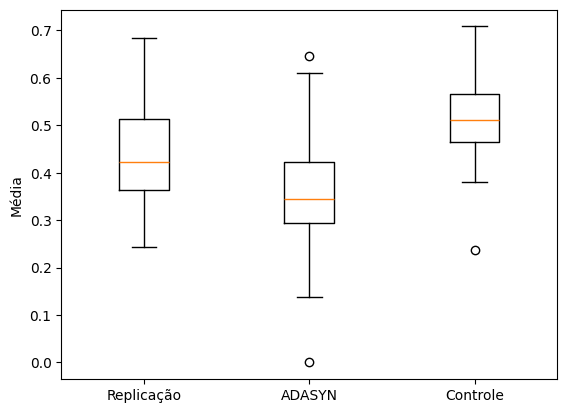

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      0.084     0.000     0.052     0.115
 (0 - 2)     -0.081     0.000    -0.112    -0.049
 (1 - 0)     -0.084     0.000    -0.115    -0.052
 (1 - 2)     -0.165     0.000    -0.196    -0.133
 (2 - 0)      0.081     0.000     0.049     0.112
 (2 - 1)      0.165     0.000     0.133     0.196



In [42]:
f_value, p_value = stats.f_oneway(pos_fscore_rep, pos_fscore_adasyn, pos_fscore_contr)

print(f_value)
print(p_value)

fig, ax = plt.subplots(1, 1)
ax.boxplot([pos_fscore_rep, pos_fscore_adasyn, pos_fscore_contr])
ax.set_xticklabels(["Replicação", "ADASYN", "Controle"])
ax.set_ylabel("Média")
plt.show()

res = stats.tukey_hsd(pos_fscore_rep, pos_fscore_adasyn, pos_fscore_contr)
print(res)